In [1]:
import numpy as np
import psrchive as ps
import os
import glob
import sys
import matplotlib.pyplot as plt
import shutil
import shlex
import subprocess

#Importing pulse portraiture stuff
import ppalign as ppa  # Import ppalign.py
import ppspline as pps  # Import ppspline.py
import pptoas as ppt  # Import pptoas.py
from pplib import write_TOAs  # and the function to write TOAs from pplib.py

/apps/skylake/software/core/anaconda2/5.1.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
input_path = "/fred/oz005/users/aparthas/reprocessing_MK/RelBin/"
psrname = "J0737-3039A"
output_path = "/fred/oz005/users/aparthas/wideband" #Choose your own output directory
template = "/fred/oz005/users/aparthas/wideband/J0737-3039A.std"

print("Wideband timing for {0}".format(psrname))
pulsar_dir = os.path.join(input_path,psrname)
print("Input directory:{0}".format(pulsar_dir))
print ("Output directory: {0}".format(output_path))
print ("Using template:{0}".format(template))

Wideband timing for J0737-3039A
Input directory:/fred/oz005/users/aparthas/reprocessing_MK/RelBin/J0737-3039A
Output directory: /fred/oz005/users/aparthas/wideband
Using template:/fred/oz005/users/aparthas/wideband/J0737-3039A.std


In [3]:
#Storing relevant data products in the arrays
align_archives = []
toa_archives = [] 

#Searches only L-band data
obs_list = sorted(glob.glob(os.path.join(pulsar_dir,"2*")))
for obs in obs_list:
    path,utc_name = os.path.split(obs)
    beams = sorted(glob.glob(os.path.join(obs,"*")))
    for beam in beams:
        freqs = sorted(glob.glob(os.path.join(beam,"1284"))) #Only L-band
        for freq in freqs:
            decimated_dir = os.path.join(freq,"decimated")
            if len(glob.glob(os.path.join(decimated_dir,"*"))) > 0:
                archive = glob.glob(os.path.join(decimated_dir,"*zap.Tp.ar"))[0]
                toa_archive = glob.glob(os.path.join(decimated_dir,"*zap.f64t8p.ar"))[0]

                align_archives.append(archive)
                toa_archives.append(toa_archive)
            else:
                print "WARNING: {0} does not have decimated products.".format(decimated_dir)

print("Total number of selected observations: {0}, {1}".format(len(align_archives),len(toa_archives)))

Total number of selected observations: 39, 39


In [4]:
#Writing out the align_archives and toa_archives as metafiles
#NOTE: Only storing archives with 775.75 MHz BW (for now - this needs to be changed to include a chopped data product!)
if not os.path.exists(os.path.join(output_path,"align_meta")):
    with open(os.path.join(output_path,"align.meta"),"w") as f:
        for item in align_archives:
            ar = ps.Archive_load(item)
            if ar.get_bandwidth() == 775.75:
                dummy = item
                f.write("{0}\n".format(item))
    f.close()
align_meta = os.path.join(output_path,"align.meta")

if not os.path.exists(os.path.join(output_path,"toa.meta")):
    with open(os.path.join(output_path,"toa.meta"),"w") as f:
        for item in toa_archives:
            ar = ps.Archive_load(item)
            if np.isclose(ar.get_bandwidth(),775.75):
                f.write("{0}\n".format(item))
    f.close()
toa_meta = os.path.join(output_path,"toa.meta")

print align_meta
print toa_meta

/fred/oz005/users/aparthas/wideband/align.meta
/fred/oz005/users/aparthas/wideband/toa.meta


In [7]:
#Creating a constant profile by using a dummy archive and a 1D template
#1d template
constant_archive = os.path.join(output_path,"{0}_constant.prof".format(psrname)) #Desired output file - aligned constant archive
if not os.path.exists(constant_archive):

    print("Loading 1D template")
    arch = ps.Archive_load(template) #Loading the 1d template
    arch.pscrunch()
    arch.fscrunch()
    arch.tscrunch()
    profile = arch.get_data()[0,0,0]

    #Creating a constant archive
    arch = ps.Archive_load(dummy) #Loading the dummy archive
    arch.dededisperse()
    arch.set_dispersion_measure(0.0)
    for subint in arch:
        for ipol in xrange(arch.get_npol()):
            for ichan in xrange(arch.get_nchan()):
                subint.set_weight(ichan, 1.0)
                arch_prof = subint.get_Profile(ipol, ichan)
                arch_prof.get_amps()[:] = profile
                
    print("Constant archive for 2D template generated")
    arch.unload(constant_archive)

else:
    print("Constand archive already exists")

Constand archive already exists


In [8]:
#Aligning archives using pp align
outfile_archive = os.path.join(output_path, "{0}_aligned.ar".format(psrname))
if not os.path.exists(outfile_archive):
    print("Aligning archives")
    ppa.align_archives(metafile=align_meta, initial_guess=constant_archive,
                       tscrunch=True, pscrunch=True, outfile=outfile_archive, 
                       niter=4, norm="rms")
print "Aligned archives: {0}".format(outfile_archive)

Aligned archives: /fred/oz005/users/aparthas/wideband/J0737-3039A_aligned.ar


In [10]:
spline_output = os.path.join(output_path,"{0}.spline".format(psrname))
if not os.path.exists(spline_output):
    print("Setting modelling parameters for PCA decomposition")
    max_ncomp = None #Set to None if the number of eigenprofiles are not known apriori
    smooth = True
    snr_cutoff = 150.0 #This is the default value. Used for filter eigenprofiles
    rchi2_tol = 0.1  #default value
    k = 3 #Default. Polynomial degree of the B-splines
    sfac = 1.0 #Default - fudge factor for smoothing the splines

    #Creating the wideband template (using PP)
    print("Making the spline model")
    dp = pps.DataPortrait(outfile_archive)
    dp.normalize_portrait("prof")
    dp.make_spline_model(max_ncomp=max_ncomp, smooth=smooth, 
                          snr_cutoff=snr_cutoff, rchi2_tol=rchi2_tol, 
                          k=k, sfac=sfac, max_nbreak=None,
                          model_name=None, quiet=False)

    print ("Created a spline model for {0}".format(psrname))
else:
    print ("Spline model already exists")

Setting modelling parameters for PCA decomposition
Making the spline model

Reading data from /fred/oz005/users/aparthas/wideband/J0737-3039A_aligned.ar on source J0737-3039A...
	P [ms]             = 22.694
        DM [cm**-3 pc]     = 0.000000
        center freq. [MHz] = 1283.5820
        bandwidth [MHz]    = 775.8
        # bins in prof     = 1024
        # channels         = 928
        # chan (mean)      = 924
        # subints          = 1
        # unzapped subint  = 1
        pol'n state        = Intensity

Performing principal component analysis on data with 1024 dimensions and 924 measurements...
B-spline interpolation model /fred/oz005/users/aparthas/wideband/J0737-3039A_aligned.ar.spl uses 1 basis profile components and 2 breakpoints (4 B-splines with k=3).
Created a spline model for J0737-3039A


/apps/skylake/software/mpi/gcc/6.4.0/openmpi/3.0.0/scipy/1.0.0-python-2.7.14/lib/python2.7/site-packages/scipy-1.0.0-py2.7-linux-x86_64.egg/scipy/interpolate/_fitpack_impl.py:296: RuntimeWarning: The spline is weighted least-squares polynomial of degree k.
fp gives the upper bound fp0 for the smoothing factor s	k=3 n=8 m=924 fp=0.001369 s=1.133919
  (k, len(t), m, fp, s)))


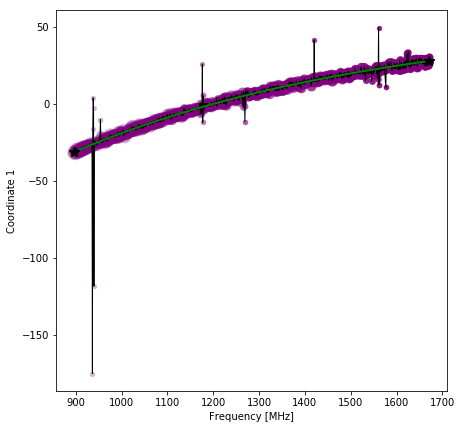

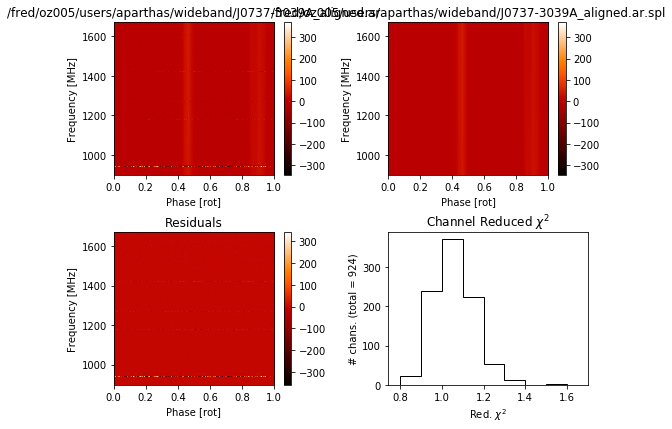

In [11]:
#dp.show_data_portrait()
dp.show_spline_curve_projections()
dp.show_model_fit()

In [12]:
#Saving the spline model and a wideband template
print("Saving the spline model")
dp.write_model(os.path.join(output_path,"{0}.spline".format(psrname)))
print("Saving the WB template")
dp.write_model_archive(os.path.join(output_path,"{0}.portrait".format(psrname)))

print("Dedispersing the portrait using pam -D and scrunching to 32 channels")
pam_D = 'pam --setnchn=32 -D {0}/{1}.portrait -e 32ch.portrait'.format(output_path,psrname)
args_pamD = shlex.split(pam_D)
proc_pamD = subprocess.Popen(args_pamD)
proc_pamD.wait()

Saving the spline model
Wrote modelfile /fred/oz005/users/aparthas/wideband/J0737-3039A.spline.
Saving the WB template

Unloaded /fred/oz005/users/aparthas/wideband/J0737-3039A.portrait.

Dedispersing the portrait using pam -D and scrunching to 32 channels


0